feature: upload model

In [5]:
import os
import modal
#import great_expectations as ge
import hopsworks
import pandas as pd

project = hopsworks.login()
fs = project.get_feature_store()

titanic_df = pd.read_csv("https://raw.githubusercontent.com/ID2223KTH/id2223kth.github.io/master/assignments/lab1/titanic.csv")
# iris_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/iris.csv")

# ===> fill in 'Embarked' with most common 'S' (2 empty)

titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')

# ===> fill in 'Age' based on name title (177 empty)

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# extract titles
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# replace titles with a more common title or as Rare
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')

# convert titles into numbers
titanic_df['Title'] = titanic_df['Title'].map(titles)    

# print('Average age of all passengers: {}'.format(titanic_df['Age'].mean()))

age_by_title = titanic_df.groupby(['Title']).mean()['Age']

for title, id in titles.items():   
    print('Average age of title {}: {}'.format(title, age_by_title[id]))


# Filling the missing values in Age with the averages of Title group
titanic_df['Age'] = titanic_df.groupby(['Title'])['Age'].apply(lambda x: x.fillna(x.mean()))

# ===> discard 'Name' and 'Title' which are included in 'Sex' and 'Age'
titanic_df = titanic_df.drop(['Name'], axis=1)
titanic_df = titanic_df.drop(['Title'], axis=1)

# ===> discard 'PassengerId' which is useless

titanic_df = titanic_df.drop(['PassengerId'], axis=1)

# ===> discard 'Cabin' which includes so many null value

# titanic_df['Cabin'] = titanic_df['Embarked'].fillna('Na')
titanic_df = titanic_df.drop(['Cabin'], axis=1)

# ===> discard 'Ticket' which is included in 'Fare' and 'pClass'

titanic_df = titanic_df.drop(['Ticket'], axis=1)

# ===> replace 'male' with 0, 'female' as 1

titanic_df['Sex'] = titanic_df['Sex'].replace('male', 0)
titanic_df['Sex'] = titanic_df['Sex'].replace('female', 1)

# ===> replace 'S' with 0, 'C' as 1, 'Q' as 2

titanic_df['Embarked'] = titanic_df['Embarked'].replace('S', 0)
titanic_df['Embarked'] = titanic_df['Embarked'].replace('C', 1)
titanic_df['Embarked'] = titanic_df['Embarked'].replace('Q', 2)

print(titanic_df.info())

titanic_fg = fs.get_or_create_feature_group(
    name="titanic_modal",
    version=1,
    primary_key=["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"], 
    description="Titanic survival dataset")
titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.


To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


Average age of title Mr: 32.368090452261306
Average age of title Miss: 21.845637583892618
Average age of title Mrs: 35.788990825688074
Average age of title Master: 4.574166666666667
Average age of title Rare: 45.54545454545455
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB
None


Uploading Dataframe: 0.00% |          | Rows 0/891 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/5316/jobs/named/titanic_modal_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x18774109f70>, None)

train: generate model (LogisticRegression)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.
2022-12-02 20:36:42,767 INFO: USE `jingyip0_featurestore`
2022-12-02 20:36:43,796 INFO: SELECT `fg0`.`survived` `survived`, `fg0`.`pclass` `pclass`, `fg0`.`sex` `sex`, `fg0`.`age` `age`, `fg0`.`sibsp` `sibsp`, `fg0`.`parch` `parch`, `fg0`.`fare` `fare`, `fg0`.`embarked` `embarked`
FROM `jingyip0_featurestore`.`titanic_modal_1` `fg0`


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5316/models/titanic_modal/13


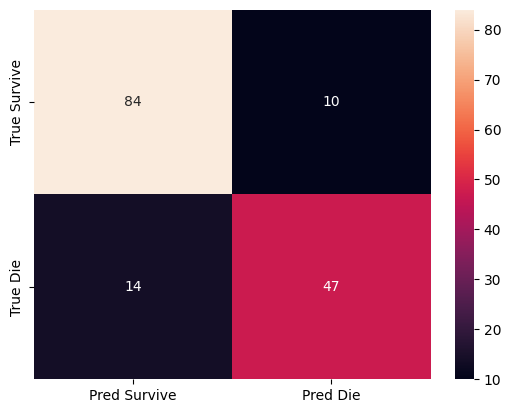

In [6]:
import os
import modal

LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().apt_install(["libgomp1"]).pip_install(["hopsworks", "seaborn", "joblib", "scikit-learn"])

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("HOPSWORKS_API_KEY"))
   def f():
       g()


def g():
    import hopsworks
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib

    # You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
    project = hopsworks.login()
    # fs is a reference to the Hopsworks Feature Store
    fs = project.get_feature_store()

    # The feature view is the input set of features for your model. The features can come from different feature groups.    
    # You can select features from different feature groups and join them together to create a feature view
    try: 
        feature_view = fs.get_feature_view(name="titanic_modal", version=1)
    except:
        iris_fg = fs.get_feature_group(name="titanic_modal", version=1)
        query = iris_fg.select_all()
        feature_view = fs.create_feature_view(name="titanic_modal",
                                          version=1,
                                          description="Read from Titanic survival dataset",
                                          labels=["survived"],
                                          query=query)    

    # You can read training data, randomly split into train/test sets of features (X) and labels (y)        
    X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

    # Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
    # model = KNeighborsClassifier(n_neighbors=2)
    # model = OneVsOneClassifier(LinearSVC(random_state=0))
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train.values.ravel())

    # Evaluate model performance using the features from the test set (X_test)
    y_pred = model.predict(X_test)

    # Compare predictions (y_pred) with the labels in the test set (y_test)
    metrics = classification_report(y_test, y_pred, output_dict=True)
    results = confusion_matrix(y_test, y_pred)

    # Create the confusion matrix as a figure, we will later store it as a PNG image file
    df_cm = pd.DataFrame(results, ['True Survive', 'True Die'],
                         ['Pred Survive', 'Pred Die'])
    cm = sns.heatmap(df_cm, annot=True)
    fig = cm.get_figure()

    # We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
    mr = project.get_model_registry()
    
    # The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
    model_dir="titanic_model"
    if os.path.isdir(model_dir) == False:
        os.mkdir(model_dir)

    # Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
    joblib.dump(model, model_dir + "/titanic_model.pkl")
    fig.savefig(model_dir + "/titanic_confusion_matrix.png")    


    # Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
    input_schema = Schema(X_train)
    output_schema = Schema(y_train)
    model_schema = ModelSchema(input_schema, output_schema)

    # Create an entry in the model registry that includes the model's name, desc, metrics
    iris_model = mr.python.create_model(
        name="titanic_modal", 
        metrics={"accuracy" : metrics['accuracy']},
        model_schema=model_schema,
        description="Titanic Survivor Predictor"
    )
    
    # Upload the model to the model registry, including all files in 'model_dir'
    iris_model.save(model_dir)
    
if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()


app.py

In [7]:
import gradio as gr
import numpy as np
from PIL import Image
import requests

import hopsworks
import joblib

project = hopsworks.login()
fs = project.get_feature_store()


mr = project.get_model_registry()
model = mr.get_model("titanic_modal", version=10)
model_dir = model.download()
model = joblib.load(model_dir + "/titanic_model.pkl")

def titanic(age, embarked, fare, parch, pclass, sex, sibsp):
    input_list = []
    input_list.append(pclass)
    input_list.append(sex)
    input_list.append(age)
    input_list.append(sibsp)
    input_list.append(parch)
    input_list.append(fare)
    input_list.append(embarked)
    # 'res' is a list of predictions returned as the label.
    res = model.predict(np.asarray(input_list).reshape(1, -1))

    # print(np.asarray(input_list).reshape(1, -1))

    # We add '[0]' to the result of the transformed 'res', because 'res' is a list, and we only want the first element.
    # flower_url = "https://raw.githubusercontent.com/featurestoreorg/serverless-ml-course/main/src/01-module/assets/" + res[0] + ".png"
    # img = Image.open(requests.get(flower_url, stream=True).raw)            
    if res == [1]:
        res = 'survive'
    else:
        res = 'die'
    return res
        
demo = gr.Interface(
    fn=titanic,
    title="Titanic Survivor Predictive Analytics",
    description="Experiment with age/embarked/fare/parch/pclass/sex/sibsp to predict if the passenger survived.",
    allow_flagging="never",
    inputs=[
        gr.inputs.Number(default=58.0, label="age"),
        gr.inputs.Number(default=0.0, label="embarked (0 for S, 1 for C, 2 for Q)"),
        gr.inputs.Number(default=153.4625, label="fare"),
        gr.inputs.Number(default=1.0, label="parch"),
        gr.inputs.Number(default=1.0, label="pclass"),
        gr.inputs.Number(default=1.0, label="sex (0 for male, 1 for female)"),
        gr.inputs.Number(default=0.0, label="sibsp")
        ],
    outputs=gr.Textbox())
demo.launch()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x187761fd9d0>, 'http://127.0.0.1:7863/', None)

daily: synthetic data passenger

In [8]:
import os
import modal

LOCAL=True

if LOCAL == False:
   stub = modal.Stub("titanic_daily")
   image = modal.Image.debian_slim().pip_install(["hopsworks==3.0.4"]) 

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("HOPSWORKS_API_KEY"))
   def f():
       g()


def generate_passenger(predict, pclass_min, pclass_max, sex_min, sex_max, age_min, age_max,
                    sibsp_min, sibsp_max, parch_min, parch_max, fare_min, fare_max):
    """
    Returns a single iris flower as a single row in a DataFrame
    """
    import pandas as pd
    import random

    df = pd.DataFrame({ "pclass": [random.randint(pclass_min,pclass_max)],
                       "sex": [random.randint(sex_min,sex_max)],
                       "age": [random.uniform(age_min, age_max)],
                       "sibsp": [random.randint(sibsp_min,sibsp_max)],
                       "parch": [random.randint(parch_min,parch_max)],
                       "fare": [random.uniform(fare_min, fare_max)],
                       "embarked": [random.randint(0,2)]
                      })
    df['survived'] = predict
    return df


def get_random_data_passenger():
    """
    Returns a DataFrame containing one random iris flower
    """
    import pandas as pd
    import random

    # pclass, sex, age, sibsp, parch, fare, embarked
    dead_df = generate_passenger(0, 2,3, 0,1, 30,80, 2,8, 1,6, 0,50)
    survival_df = generate_passenger(1, 1,2, 1,1, 0,40, 0,1, 0,0, 0,512)

    # randomly pick one of these 3 and write it to the featurestore
    pick_random = random.randint(0,99)
    if (pick_random%2):
        titanic_df = dead_df
        print(titanic_df)
        print("Dead added")
    else:
        titanic_df = survival_df
        print(titanic_df)
        print("Survival added")

    return titanic_df


def g():
    import hopsworks
    import pandas as pd

    project = hopsworks.login()
    fs = project.get_feature_store()

    titanic_df = get_random_data_passenger()

    titanic_fg = fs.get_feature_group(name="titanic_modal",version=1)
    titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})

if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        stub.deploy("iris_daily")
        with stub.run():
            f()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.
   pclass  sex        age  sibsp  parch       fare  embarked  survived
0       1    1  31.513106      1      0  500.18614         1         1
Survival added


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/5316/jobs/named/titanic_modal_1_offline_fg_backfill/executions


inference: monitor prediction

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.

2022-12-02 20:38:41,611 INFO: USE `jingyip0_featurestore`
2022-12-02 20:38:42,611 INFO: SELECT `fg0`.`pclass` `pclass`, `fg0`.`sex` `sex`, `fg0`.`age` `age`, `fg0`.`sibsp` `sibsp`, `fg0`.`parch` `parch`, `fg0`.`fare` `fare`, `fg0`.`embarked` `embarked`
FROM `jingyip0_featurestore`.`titanic_modal_1` `fg0`


61
Passenger predicted: survived
2022-12-02 20:38:46,033 INFO: USE `jingyip0_featurestore`
2022-12-02 20:38:47,034 INFO: SELECT `fg0`.`survived` `survived`, `fg0`.`pclass` `pclass`, `fg0`.`sex` `sex`, `fg0`.`age` `age`, `fg0`.`sibsp` `sibsp`, `fg0`.`parch` `parch`, `fg0`.`fare` `fare`, `fg0`.`embarked` `embarked`
FROM `jingyip0_featurestore`.`titanic_modal_1` `fg0`


survived      1.0
pclass        1.0
sex           1.0
age          36.0
sibsp         1.0
parch         2.0
fare        120.0
embarked      0.0
Name: 714, dtype: float64
Passenger actual: survived


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/5316/jobs/named/titanic_predictions_1_offline_fg_backfill/executions
2022-12-02 20:38:52,379 INFO: USE `jingyip0_featurestore`
2022-12-02 20:38:53,400 INFO: SELECT `fg0`.`prediction` `prediction`, `fg0`.`label` `label`, `fg0`.`datetime` `datetime`
FROM `jingyip0_featurestore`.`titanic_predictions_1` `fg0`


Uploading: 0.000%|          | 0/31767 elapsed<00:00 remaining<?

Number of different passenger predictions to date: 2


Uploading: 0.000%|          | 0/12580 elapsed<00:00 remaining<?

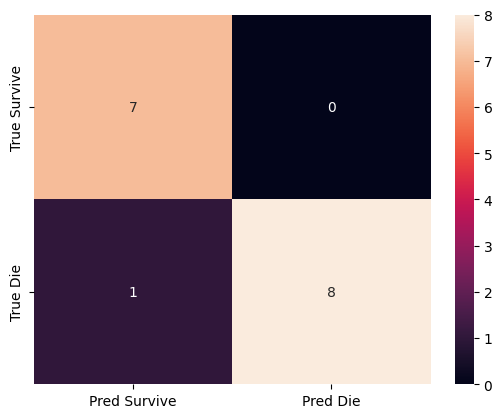

In [9]:
import os
import modal
    
LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   hopsworks_image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"])
   @stub.function(image=hopsworks_image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("HOPSWORKS_API_KEY"))
   def f():
       g()

def g():
    import pandas as pd
    import hopsworks
    import joblib
    import datetime
    from PIL import Image
    from datetime import datetime
    import dataframe_image as dfi
    from sklearn.metrics import confusion_matrix
    from matplotlib import pyplot
    import seaborn as sns
    import requests
    import random

    project = hopsworks.login()
    fs = project.get_feature_store()
    
    mr = project.get_model_registry()
    model = mr.get_model("titanic_modal", version=10)
    model_dir = model.download()
    model = joblib.load(model_dir + "/titanic_model.pkl")
    
    feature_view = fs.get_feature_view(name="titanic_modal", version=1)
    batch_data = feature_view.get_batch_data()
    # print(batch_data[batch_data.size-1])
    
    y_pred = model.predict(batch_data)
    # print(batch_data)
    # print(y_pred)
    OFFSET = random.randint(1,200)
    print (OFFSET)
    survival = y_pred[y_pred.size-OFFSET]
    if survival == 1:
        survival = 'survived'
    else:
        survival = 'dead'
    print("Passenger predicted: " + survival)
    
    titanic_fg = fs.get_feature_group(name="titanic_modal", version=1)
    df = titanic_fg.read()
    # print(df["variety"])
    label = df.iloc[-OFFSET]["survived"]
    print(df.iloc[-OFFSET])
    if label == 1:
        label = 'survived'
    else:
        label = 'dead'
    print("Passenger actual: " + label)
    dataset_api = project.get_dataset_api()  
    
    monitor_fg = fs.get_or_create_feature_group(name="titanic_predictions",
                                                version=1,
                                                primary_key=["datetime"],
                                                description="Titanic passenger Prediction/Outcome Monitoring"
                                                )
    
    now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    data = {
        'prediction': [survival],
        'label': [label],
        'datetime': [now],
       }
    monitor_df = pd.DataFrame(data)
    monitor_fg.insert(monitor_df, write_options={"wait_for_job" : False})
    
    history_df = monitor_fg.read()
    # Add our prediction to the history, as the history_df won't have it - 
    # the insertion was done asynchronously, so it will take ~1 min to land on App
    history_df = pd.concat([history_df, monitor_df])


    df_recent = history_df.tail(5)
    dfi.export(df_recent, './df_recent.png', table_conversion = 'matplotlib')
    dataset_api.upload("./df_recent.png", "Resources/images", overwrite=True)
    
    predictions = history_df[['prediction']]
    labels = history_df[['label']]

    # Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
    print("Number of different passenger predictions to date: " + str(predictions.value_counts().count()))
    if predictions.value_counts().count() == 2:
        results = confusion_matrix(labels, predictions)
    
        df_cm = pd.DataFrame(results, ['True Survive', 'True Die'],
                            ['Pred Survive', 'Pred Die'])
    
        cm = sns.heatmap(df_cm, annot=True)
        fig = cm.get_figure()
        fig.savefig("./confusion_matrix.png")
        dataset_api.upload("./confusion_matrix.png", "Resources/images", overwrite=True)
    else:
        print("You need 2 different passenger predictions to create the confusion matrix.")
        print("Run the batch inference pipeline more times until you get 2 different titanic passenger predictions") 


if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()



app.py

In [10]:
import gradio as gr
from PIL import Image
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

dataset_api = project.get_dataset_api()

dataset_api.download("Resources/images/df_recent.png", overwrite=True)
dataset_api.download("Resources/images/confusion_matrix.png", overwrite=True)

with gr.Blocks() as demo:   
    with gr.Row():
      with gr.Column():
          gr.Label("Recent Prediction History")
          input_img = gr.Image("df_recent.png", elem_id="recent-predictions")
      with gr.Column():          
          gr.Label("Confusion Maxtrix with Historical Prediction Performance")
          input_img = gr.Image("confusion_matrix.png", elem_id="confusion-matrix")        

demo.launch(share=True)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5316
Connected. Call `.close()` to terminate connection gracefully.


Downloading: 0.000%|          | 0/31767 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/12580 elapsed<00:00 remaining<?

Running on local URL:  http://127.0.0.1:7864
2022-12-02 20:39:58,804 INFO: Connected (version 2.0, client OpenSSH_7.6p1)
2022-12-02 20:39:59,689 INFO: Authentication (publickey) successful!
Running on public URL: https://74973a6eb43f5eed.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x18778e88be0>,
 'http://127.0.0.1:7864/',
 'https://74973a6eb43f5eed.gradio.app')